In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels
import csv
import pickle

# Processing Data from PostGRES Output

Creating a single JSON file for each participant from PostGRES data that contains a single list of all participant data

In [10]:
fileprefix = "final_3" # pilot_[1,2,4]
filepath = '../results/{}_results_anonymized.json'.format(fileprefix)


In [11]:
with open(filepath, 'r') as f:
    all_data = json.load(f)

In [12]:
part_data = {}

count = 0
for participant in all_data['values']:
    count+=1
    print(count, participant[2])
    try:
        part_object = json.loads(participant[17])
        part_object["Beginhit"] = participant[11]
        part_object["Beginexp"] = participant[12]
        part_object["Endhit"] = participant[13]
        part_object["psiturkStatus"] = participant[15]
        part_object["browser"] = participant[5]
        part_object["platform"] = participant[6]
        part_object["language"] = participant[7]
        
        if part_object["workerId"].startswith("debug"):
            continue

        part_data[part_object["workerId"]] = part_object
        with open('../results/anonymized_data/{}_{}.json'.format(fileprefix, part_object['workerId']), 'w') as fw:
            json.dump(part_object, fw)
    except:
        print("Fail")
        continue;

1 w65101683
2 w11348126
3 w12522314
4 w20506940
5 w56165539
6 w76048971
7 w69599227
8 w15148922
9 w85446667
10 w30962485
11 w31622188
12 w13321798
13 w53675321
14 w42808871
15 w13619803
16 w59852358
17 w33842342
18 w98179581
19 w97502137
20 w81787693
21 w30735700
22 w45011597
23 w96197731
24 w34569442
25 w66484773
26 w58974615
27 w91994147
28 w97150299
29 w37980193
30 w23091479
31 w72360089
32 w55457975
33 w48226837
34 w44337403
35 w90007066
36 w24680370
37 w87568473
38 w98480688
39 w14753092
40 w47359213
41 w39322619
42 w72694622
43 w81660847
44 w13510001
45 w98138444
46 w48119377
47 w88998301
48 w71432619
49 w46802989
50 w61276977
51 w32708631
52 w11493799
53 w26371268
54 w24484553
55 w80430331
56 w11158197
57 w95819391
58 w70037142
59 w81352075
60 w38970667
61 w10052419
62 w61003141
63 w35940392
64 w63406356
65 w31962968
66 w21224152
67 w64665231
68 w52661172
69 w27096118
70 w22087204
71 w14893388
72 w26548314
73 w87218775
74 w76931069
75 w54306323
76 w57329138
77 w98232351
78 w3838

In [13]:
part_data.keys()


dict_keys(['w65101683', 'w11348126', 'w12522314', 'w20506940', 'w56165539', 'w76048971', 'w69599227', 'w15148922', 'w85446667', 'w30962485', 'w31622188', 'w13321798', 'w53675321', 'w42808871', 'w13619803', 'w59852358', 'w33842342', 'w98179581', 'w97502137', 'w81787693', 'w30735700', 'w45011597', 'w96197731', 'w34569442', 'w66484773', 'w58974615', 'w91994147', 'w97150299', 'w37980193', 'w23091479', 'w72360089', 'w55457975', 'w48226837', 'w44337403', 'w90007066', 'w24680370', 'w87568473', 'w98480688', 'w14753092', 'w47359213', 'w39322619', 'w72694622', 'w81660847', 'w13510001', 'w98138444', 'w48119377', 'w88998301', 'w71432619', 'w46802989', 'w61276977', 'w32708631', 'w11493799', 'w26371268', 'w24484553', 'w80430331', 'w11158197', 'w95819391', 'w70037142', 'w81352075', 'w38970667', 'w10052419', 'w61003141', 'w35940392', 'w63406356', 'w31962968', 'w21224152', 'w64665231', 'w52661172', 'w27096118', 'w22087204', 'w14893388', 'w26548314', 'w87218775', 'w76931069', 'w54306323', 'w57329138', '

# Reading Data from Already Created Participant Data Files

In [2]:
fileprefix = "final" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [3]:
part_data = {}
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
        part_data[participant["workerId"]] = participant



In [4]:
len(part_data.keys())

258

# End of Pre-Processing

The remaining notebook is used to check completeness of data and assign bonuses to participants based on performance 

# Analyzing Trial Data

Create a list of objects, one for each participant's data

In [30]:
part_stats_dicts = []
for participant in part_data.values():
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    rewardsWithheld = []
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
        lastTrialStamp = participant['data'][-1]['dateTime']
    except:
        print("No data")
        continue
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    stroop_timestamps = {
        "1" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        },
        "2" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        }
    }
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    stroop1Completed = 0
    stroop1Correct = 0
    stroop2Completed = 0
    stroop2Correct = 0
    last_trial = participant['data'][0]
    finishHITReached = False
    demographicsAvailable = False
    feedback = ""
    alreadyParticipated = ""
    comments = ""
    final_quiz_responses = None
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
        if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
            print("{}\t{}\t{}".format(trial_type, trial_id, idx))
        if trial_id == "stroop_1_ready_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["start"] = trial['dateTime']
            
        if trial_id == "stroop_2_ready_1" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["start"] = trial['dateTime']
            
        if trial_id == "finish_distractor_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["end"] = trial['dateTime']
            stroop_timestamps["1"]["done"] = True
            
        if trial_id == "finish_distractor_2" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["end"] = trial['dateTime']
            stroop_timestamps["2"]["done"] = True
            
        if trial_id == "mouselab_instructions_1" and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        if "congruent" in trial_id or "incongruent" in trial_id or "unrelated" in trial_id:
            if not stroop_timestamps["1"]["done"]:
                stroop1Completed += 1
                
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop1Correct += 1
                
            else:
                stroop2Completed += 1
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop2Correct += 1
                    
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        if trial_id.startswith("final_quiz"):
            final_quiz_responses = trial['trialdata']['response']
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
        elif trial_type == 'survey-text':
            feedback = trial['trialdata']['response']['Q0']
            alreadyParticipated = trial['trialdata']['response']['Q1']
            comments = trial['trialdata']['response']['Q2']
        
        if trial_type == 'html-button-response':
            if "Finish HIT" in trial['trialdata']['stimulus']:
                finishHITReached = True
        last_trial = trial

    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps, stroop_timestamps["1"], stroop_timestamps["2"]], ["mdp", "s1", "s2"]):
        if obj["start"] > 0 and obj["end"] == 0:
            
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if not dropoutPoint:
        if len(trialLengths) == 0:
            dropoutPoint = "beginning"
        elif not finishHITReached:
            dropoutPoint = "finishHIT"
            
    if dropoutPoint:
        print(participant['workerId'], dropoutPoint)
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "age":age,
        "colorblind":colorblind,
        "gender":gender,
        "condition": participant['condition'],
        "stroop1Length" : (stroop_timestamps["1"]["end"] - stroop_timestamps["1"]["start"]) / 1000,
        "stroop2Length" : (stroop_timestamps["2"]["end"] - stroop_timestamps["2"]["start"]) / 1000,
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "stroop1Completed" : stroop1Completed,
        "stroop2Completed" : stroop2Completed,
        "stroop1Correct" : stroop1Correct,
        "stroop2Correct" : stroop2Correct,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "alreadyParticipated": alreadyParticipated,
        "comments": comments,
        "finishHITReached": finishHITReached,
        "demographicsAvailable": demographicsAvailable,
        "final_quiz_responses": final_quiz_responses
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["stroop1Length"] + part_stats_dict["mouselabLength"] + part_stats_dict["stroop2Length"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

60fd5adad03767cff6dddda8
631a24dfca851aac1863e4a4
601903cdcd7cd6213bf60d64
601903cdcd7cd6213bf60d64 mdp
5c629b836e03a00001d47bdd
615f4115250650ede6f83270
608c0288bce208aa19b5e302
60e43d16eb3536f1618652fb
6165d04961f94aba783d4529
611cccc7df12bfa05e6135e0
615aff05691d41b8ce734ca0
6115fcb4fcbab96f3ceb1734
5d7d00bb64f400001bd72301
60143a1a222eb43daf203877
5dafea4de40355001651fa2f
5ae7cdd9a0e4390001f08f12
5d21e78e5a2cea0016a843c4
6081e753b16df5194cf90f49
5e5012ec47808406305d6a0d
6155d029515651d612ad2141
5e89d0a17ec160000888ee98
5ebdb1414b3e5d0e1e46e76d
604b169fe4b7991ec08da3a6
60217ceca41dfb1639d152a7
5efd2964d36f63162f263795
5f16ccc87d339d0008e08016
5f16ccc87d339d0008e08016 s1
60fe8586944a3f20fd5e8db2
5ec51242bc5aac433c0450ec
60a2d0f8a996c447692d4b73
60a2d0f8a996c447692d4b73 s2
5ec79cbd44972a1fceed2719
5f388a9c9604723a294bc377
5f69e356d68b93020e622bf2
60f88d7fef1959734061e5a7
5974ce5364b35a00019dd811
5974ce5364b35a00019dd811 beginning
6088a7e22d5b98ef3f813a22
610ce0a48fc7e68abc4070c1
610ce

In [6]:
stats_df = pd.DataFrame(part_stats_dicts)
print(len(stats_df))
filter_cols = ["workerId", "Beginhit", "hitLength", "expLength", "condition", "stroop1Length", "stroop1Completed", "stroop1Correct", "numQuizAttempts", "numTrialsCompleted", "mouselabLength", "finalScore", "propWithheld", "stroop2Length","stroop2Completed", "stroop2Correct", "dropoutPoint", "finishHITReached", "psiturkStatus", "effort", "demographicsAvailable"]
stats_df[filter_cols]

255


,workerId,Beginhit,hitLength,expLength,condition,stroop1Length,stroop1Completed,stroop1Correct,numQuizAttempts,numTrialsCompleted,...,finalScore,propWithheld,stroop2Length,stroop2Completed,stroop2Correct,dropoutPoint,finishHITReached,psiturkStatus,effort,demographicsAvailable
0,60fd5adad03767cff6dddda8,2022-10-04 08:45:04.516349,2099.000,2083.000,0,765.522,450,385,1.0,30,...,1149.00,0.00,578.300,450,383,None,True,3,0,True
1,631a24dfca851aac1863e4a4,2022-09-28 12:26:55.547837,2573.000,2569.000,1,0.000,0,0,2.0,120,...,1293.75,0.75,0.000,0,0,None,True,3,0,True
2,601903cdcd7cd6213bf60d64,2022-09-30 16:23:11.910250,191.323,191.323,1,0.000,0,0,1.0,0,...,0.00,NaN,0.000,0,0,mdp,False,6,-1,False
3,5c629b836e03a00001d47bdd,2022-09-28 12:27:02.620224,2579.000,2566.000,0,689.265,450,438,2.0,30,...,376.00,0.00,640.502,450,442,None,True,3,0,True
4,615f4115250650ede6f83270,2022-09-28 12:24:10.485070,2303.000,2293.000,1,0.000,0,0,2.0,120,...,898.00,0.75,0.000,0,0,None,True,3,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,60f43127b2b2e32120869426,2022-09-30 16:41:56.471896,2101.000,2085.000,1,0.000,0,0,1.0,120,...,1029.25,0.75,0.000,0,0,None,True,3,0,True
251,6164b6c530d1e621012eedda,2022-09-30 16:25:02.960767,3702.000,3682.000,0,805.266,450,426,1.0,30,...,329.00,0.00,751.894,450,432,None,True,3,0,True
252,5f946b72d654c628ea868716,2022-09-30 16:23:48.749066,1757.000,1751.000,1,0.000,0,0,2.0,120,...,1305.00,0.75,0.000,0,0,None,True,3,0,True
253,5d31c6bac88f0e00164c3ccb,2022-10-04 08:45:43.397696,2428.000,2424.000,0,826.096,450,424,2.0,30,...,501.00,0.00,544.152,450,423,None,True,3,0,True


In [7]:
# Filter those who dropped out immediately

immediate_drops = stats_df.loc[(stats_df.dropoutPoint == "beginning")]
print(len(immediate_drops))
immediate_drops

10


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,feedback,alreadyParticipated,comments,finishHITReached,demographicsAvailable,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
32,5974ce5364b35a00019dd811,2022-09-28 14:30:57.512401,NaT,2022-09-28 14:31:03.891129,6,firefox,windows,fr,5.578,5.578,...,,,,False,False,0.0,0.0,-5.578,NaN,NaN
54,60ceaf82080f57fb967341d2,2022-09-28 12:24:39.380921,NaT,2022-09-28 12:25:06.389391,2,safari,macos,en-GB,68.676,68.676,...,,,,False,False,0.0,0.0,-68.676,NaN,NaN
62,5f2dc74f1f22490fbef32149,2022-09-28 12:24:13.873802,NaT,2022-09-28 12:24:21.137778,2,opera,windows,pt-PT,0.000,0.000,...,,,,False,False,0.0,0.0,0.000,NaN,NaN
74,5df97fcd11d8796fd29e85e3,2022-09-30 16:24:28.612334,NaT,2022-09-30 16:24:41.275108,6,chrome,windows,hu-HU,62.457,62.457,...,,,,False,False,0.0,0.0,-62.457,NaN,NaN
106,60fef59b4d85390bc0357a7d,2022-09-28 13:07:40.282047,NaT,2022-09-28 13:07:48.397023,2,chrome,windows,pl-PL,0.000,0.000,...,,,,False,False,0.0,0.0,0.000,NaN,NaN
116,60e5d224c2070a7adc97befe,2022-09-29 15:05:00.551614,NaT,2022-09-29 15:05:06.074995,2,firefox,windows,pt-PT,0.000,0.000,...,,,,False,False,0.0,0.0,0.000,NaN,NaN
152,5ff0a3d22c2ee6fa5d47c312,2022-09-29 15:06:26.212598,NaT,2022-09-29 15:06:32.903018,6,chrome,windows,en-US,0.000,0.000,...,,,,False,False,0.0,0.0,0.000,NaN,NaN
157,5e7a54cb26ed710245408b81,2022-09-28 13:05:55.456151,NaT,2022-09-28 13:06:12.903064,2,chrome,windows,it-IT,0.000,0.000,...,,,,False,False,0.0,0.0,0.000,NaN,NaN
193,5beef9e0c9f863000124cadf,2022-09-29 15:05:15.682911,NaT,2022-09-29 15:05:29.339722,6,chrome,windows,es-419,13.327,13.327,...,,,,False,False,0.0,0.0,-13.327,NaN,NaN
230,5e98b398e4a84f0eb3755e51,2022-09-30 16:24:16.954647,NaT,2022-09-30 16:24:35.025845,6,firefox,windows,pl,114.531,114.531,...,,,,False,False,0.0,0.0,-114.531,NaN,NaN


In [8]:
no_immediate_drops = stats_df.loc[(stats_df.dropoutPoint != "beginning")]
print(len(no_immediate_drops))
no_immediate_drops

245


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,feedback,alreadyParticipated,comments,finishHITReached,demographicsAvailable,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,60fd5adad03767cff6dddda8,2022-10-04 08:45:04.516349,2022-10-04 09:20:04.042424,2022-10-04 08:45:20.306048,3,chrome,windows,en-US,2099.000,2083.000,...,"No, it was simple","No, it was a first",Interesting study,True,True,1149.00,1893.625,-189.375,12859.066667,0.00
1,631a24dfca851aac1863e4a4,2022-09-28 12:26:55.547837,2022-09-28 13:09:48.964001,2022-09-28 12:26:59.882002,3,chrome,windows,pt-PT,2573.000,2569.000,...,,no,,True,True,1293.75,2391.054,-177.946,12047.233333,0.75
2,601903cdcd7cd6213bf60d64,2022-09-30 16:23:11.910250,NaT,2022-09-30 16:23:15.701885,6,opera,windows,pl-PL,191.323,191.323,...,,,,False,False,0.00,109.462,-81.861,NaN,NaN
3,5c629b836e03a00001d47bdd,2022-09-28 12:27:02.620224,2022-09-28 13:10:02.616965,2022-09-28 12:27:16.434442,3,chrome,windows,ru-RU,2579.000,2566.000,...,no,no,no,True,True,376.00,2232.808,-333.192,11376.300000,0.00
4,615f4115250650ede6f83270,2022-09-28 12:24:10.485070,2022-09-28 13:02:34.015761,2022-09-28 12:24:20.439371,3,chrome,windows,en-GB,2303.000,2293.000,...,No,No,N/A,True,True,898.00,2102.181,-190.819,14247.783333,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,60f43127b2b2e32120869426,2022-09-30 16:41:56.471896,2022-09-30 17:16:58.166111,2022-09-30 16:42:13.018000,3,chrome,windows,hu-HU,2101.000,2085.000,...,No.,"No, I did not.",It was a good experiment.,True,True,1029.25,1483.817,-601.183,10523.500000,0.75
251,6164b6c530d1e621012eedda,2022-09-30 16:25:02.960767,2022-09-30 17:26:45.684791,2022-09-30 16:25:23.541249,3,chrome,windows,en-ZA,3702.000,3682.000,...,no,no,,True,True,329.00,2105.392,-1576.608,13444.700000,0.00
252,5f946b72d654c628ea868716,2022-09-30 16:23:48.749066,2022-09-30 16:53:06.739760,2022-09-30 16:23:55.591844,3,opera,windows,pl-PL,1757.000,1751.000,...,,I haven't participated in any HITs before,,True,True,1305.00,1581.894,-169.106,10831.450000,0.75
253,5d31c6bac88f0e00164c3ccb,2022-10-04 08:45:43.397696,2022-10-04 09:26:12.225900,2022-10-04 08:45:47.809470,3,chrome,windows,en,2428.000,2424.000,...,everything was easy,I did it for the first time,have a nice day,True,True,501.00,2101.392,-322.608,13799.666667,0.00


In [9]:
# Partial compensation rates

gbp_hourly = 6
secondly_rate = gbp_hourly / (3600)

In [10]:
# Early quitters - Psiturk status 6 or 2, and no quiz attempts completed

early_quitters = no_immediate_drops.loc[(no_immediate_drops.psiturkStatus == 6) & (no_immediate_drops.numQuizAttempts == 0)]
early_quitters.loc[:,'bonus'] = (early_quitters['stroop1Length'] + early_quitters['mouselabLength'] + early_quitters['stroop2Length']) * secondly_rate
print(len(early_quitters))

# Printing bonuses
for idx, row in early_quitters.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))
    
early_quitters

5
6103872a37b1dd5b8f350237, 2.76
5f3a76043bb11c6786e731bf, 0.01
6048ed4af6f547ddf5a9fbf7, 0.59
60e94a95eed542e75d045ca6, 1.90
616cb46402d68cdfc6e8c8db, 0.00


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_32323/1715624146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_quitters.loc[:,'bonus'] = (early_quitters['stroop1Length'] + early_quitters['mouselabLength'] + early_quitters['stroop2Length']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,alreadyParticipated,comments,finishHITReached,demographicsAvailable,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
56,6103872a37b1dd5b8f350237,2022-09-30 16:24:38.185967,NaT,2022-09-30 16:25:11.045467,6,chrome,windows,es-MX,1733.847,1733.847,...,,,False,False,0.0,1653.345,-80.502,NaN,NaN,2.755575
111,5f3a76043bb11c6786e731bf,2022-09-29 15:08:20.681143,NaT,2022-09-29 15:08:25.840209,6,chrome,windows,hu-HU,31.922,31.922,...,,,False,False,0.0,7.860,-24.062,NaN,NaN,0.013100
130,6048ed4af6f547ddf5a9fbf7,2022-09-28 12:25:25.603673,NaT,2022-09-28 12:25:30.627254,6,chrome,windows,en-GB,393.489,393.489,...,,,False,False,0.0,353.675,-39.814,NaN,NaN,0.589458
207,60e94a95eed542e75d045ca6,2022-09-29 15:05:03.234483,NaT,2022-09-29 15:05:14.987148,6,chrome,windows,en-US,1412.962,1412.962,...,,,False,False,0.0,1140.473,-272.489,NaN,NaN,1.900788
209,616cb46402d68cdfc6e8c8db,2022-09-30 16:24:41.581166,NaT,2022-09-30 16:41:50.128025,6,firefox,windows,es-MX,40.212,40.212,...,,,False,False,0.0,0.000,-40.212,NaN,NaN,0.000000


In [11]:
# Filtering those who failed the quiz more than 4 times

failed_quiz = no_immediate_drops.loc[(no_immediate_drops.numQuizAttempts > 0) & (no_immediate_drops.numTrialsCompleted == 0)]
failed_quiz.loc[:,'bonus'] = (failed_quiz['stroop1Length'] + failed_quiz['mouselabLength'] + failed_quiz['stroop2Length']) * secondly_rate
print(len(failed_quiz))

# Printing bonuses
for idx, row in failed_quiz.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))
failed_quiz

12
601903cdcd7cd6213bf60d64, 0.18
6155a6764b2556042551a827, 2.98
614c58edcb19b4cb3a486666, 0.12
6064b073d8b83b30f7975c8d, 1.39
6148c1569b73a46eff7db516, 0.37
605483d3fc701f842cbc5bde, 1.35
608c90af2b9dc5f9f35bb583, 2.13
60ed013b51f6cb78bb82f024, 2.27
616a94b54cf4a5cde4d9c015, 0.71
607417a6a2b03d66922db6c1, 1.84
63012780a9852e8d7977a5fd, 2.75
5efc4c06d5d77c0008dd1792, 3.52


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_32323/3510295888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_quiz.loc[:,'bonus'] = (failed_quiz['stroop1Length'] + failed_quiz['mouselabLength'] + failed_quiz['stroop2Length']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,alreadyParticipated,comments,finishHITReached,demographicsAvailable,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
2,601903cdcd7cd6213bf60d64,2022-09-30 16:23:11.910250,NaT,2022-09-30 16:23:15.701885,6,opera,windows,pl-PL,191.323,191.323,...,,,False,False,0.0,109.462,-81.861,NaN,NaN,0.182437
59,6155a6764b2556042551a827,2022-09-29 15:05:23.312413,2022-09-29 15:39:58.702978,2022-09-29 15:05:32.375139,3,chrome,windows,en-ZA,2075.000,2066.000,...,,,True,True,0.0,1787.170,-278.830,NaN,NaN,2.978617
67,614c58edcb19b4cb3a486666,2022-09-28 14:11:04.142165,NaT,2022-09-28 14:11:11.593902,6,chrome,windows,en-GB,105.343,105.343,...,,,False,False,0.0,74.788,-30.555,NaN,NaN,0.124647
80,6064b073d8b83b30f7975c8d,2022-09-29 15:05:04.515864,2022-09-29 15:21:03.871062,2022-09-29 15:05:15.135039,3,chrome,windows,hu-HU,959.000,948.000,...,,no,True,True,0.0,833.968,-114.032,NaN,NaN,1.389947
117,6148c1569b73a46eff7db516,2022-09-30 16:24:57.468096,NaT,2022-09-30 16:25:08.326507,6,chrome,windows,es-419,433.558,433.558,...,,,False,False,0.0,219.794,-213.764,NaN,NaN,0.366323
129,605483d3fc701f842cbc5bde,2022-09-29 15:07:01.371608,2022-09-29 15:21:58.471261,2022-09-29 15:07:05.991028,3,chrome,windows,pt-PT,897.000,892.000,...,,no,True,True,0.0,809.741,-82.259,NaN,NaN,1.349568
133,608c90af2b9dc5f9f35bb583,2022-09-29 15:04:59.347106,NaT,2022-09-29 15:05:10.072562,6,chrome,windows,en-NL,1438.930,1438.930,...,,,False,False,0.0,1275.566,-163.364,NaN,NaN,2.125943
150,60ed013b51f6cb78bb82f024,2022-09-28 12:25:23.996725,NaT,2022-09-28 12:25:37.465623,6,chrome,windows,pt-PT,1921.777,1921.777,...,,,False,False,0.0,1359.636,-562.141,NaN,NaN,2.266060
169,616a94b54cf4a5cde4d9c015,2022-09-28 12:27:28.753630,NaT,2022-09-28 12:27:42.973160,6,chrome,windows,en-ZA,580.219,580.219,...,,,False,False,0.0,428.834,-151.385,NaN,NaN,0.714723
196,607417a6a2b03d66922db6c1,2022-09-30 16:20:00.827451,NaT,2022-09-30 16:20:08.458077,6,chrome,windows,en-US,1205.495,1205.495,...,,,False,False,0.0,1105.314,-100.181,NaN,NaN,1.842190


In [12]:
for idx, row in failed_quiz.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

601903cdcd7cd6213bf60d64	1
6155a6764b2556042551a827	0
614c58edcb19b4cb3a486666	1
6064b073d8b83b30f7975c8d	1
6148c1569b73a46eff7db516	1
605483d3fc701f842cbc5bde	1
608c90af2b9dc5f9f35bb583	0
60ed013b51f6cb78bb82f024	0
616a94b54cf4a5cde4d9c015	1
607417a6a2b03d66922db6c1	1
63012780a9852e8d7977a5fd	1
5efc4c06d5d77c0008dd1792	0


In [13]:
eligible = no_immediate_drops.loc[(~no_immediate_drops['workerId'].isin(early_quitters.workerId)) & (~no_immediate_drops['workerId'].isin(failed_quiz.workerId))]
print(len(eligible))
eligible

228


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,feedback,alreadyParticipated,comments,finishHITReached,demographicsAvailable,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,60fd5adad03767cff6dddda8,2022-10-04 08:45:04.516349,2022-10-04 09:20:04.042424,2022-10-04 08:45:20.306048,3,chrome,windows,en-US,2099.0,2083.0,...,"No, it was simple","No, it was a first",Interesting study,True,True,1149.00,1893.625,-189.375,12859.066667,0.00
1,631a24dfca851aac1863e4a4,2022-09-28 12:26:55.547837,2022-09-28 13:09:48.964001,2022-09-28 12:26:59.882002,3,chrome,windows,pt-PT,2573.0,2569.0,...,,no,,True,True,1293.75,2391.054,-177.946,12047.233333,0.75
3,5c629b836e03a00001d47bdd,2022-09-28 12:27:02.620224,2022-09-28 13:10:02.616965,2022-09-28 12:27:16.434442,3,chrome,windows,ru-RU,2579.0,2566.0,...,no,no,no,True,True,376.00,2232.808,-333.192,11376.300000,0.00
4,615f4115250650ede6f83270,2022-09-28 12:24:10.485070,2022-09-28 13:02:34.015761,2022-09-28 12:24:20.439371,3,chrome,windows,en-GB,2303.0,2293.0,...,No,No,N/A,True,True,898.00,2102.181,-190.819,14247.783333,0.75
5,608c0288bce208aa19b5e302,2022-09-30 16:24:12.902600,2022-09-30 16:58:34.980688,2022-09-30 16:24:22.402907,3,chrome,windows,pl-PL,2062.0,2052.0,...,no,no,no,True,True,1137.00,1742.442,-309.558,11051.766667,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,60f43127b2b2e32120869426,2022-09-30 16:41:56.471896,2022-09-30 17:16:58.166111,2022-09-30 16:42:13.018000,3,chrome,windows,hu-HU,2101.0,2085.0,...,No.,"No, I did not.",It was a good experiment.,True,True,1029.25,1483.817,-601.183,10523.500000,0.75
251,6164b6c530d1e621012eedda,2022-09-30 16:25:02.960767,2022-09-30 17:26:45.684791,2022-09-30 16:25:23.541249,3,chrome,windows,en-ZA,3702.0,3682.0,...,no,no,,True,True,329.00,2105.392,-1576.608,13444.700000,0.00
252,5f946b72d654c628ea868716,2022-09-30 16:23:48.749066,2022-09-30 16:53:06.739760,2022-09-30 16:23:55.591844,3,opera,windows,pl-PL,1757.0,1751.0,...,,I haven't participated in any HITs before,,True,True,1305.00,1581.894,-169.106,10831.450000,0.75
253,5d31c6bac88f0e00164c3ccb,2022-10-04 08:45:43.397696,2022-10-04 09:26:12.225900,2022-10-04 08:45:47.809470,3,chrome,windows,en,2428.0,2424.0,...,everything was easy,I did it for the first time,have a nice day,True,True,501.00,2101.392,-322.608,13799.666667,0.00


In [14]:
data_actually_complete = []

In [15]:
incomplete_data = eligible.loc[(eligible.psiturkStatus != 3) & (~eligible.workerId.isin(data_actually_complete))]
print(len(incomplete_data))
incomplete_data

22


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,feedback,alreadyParticipated,comments,finishHITReached,demographicsAvailable,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
24,5f16ccc87d339d0008e08016,2022-09-28 12:34:19.334075,NaT,2022-09-28 12:34:30.950009,2,chrome,linux,en-GB,826.519,826.519,...,,,,False,False,0.00,696.234,-130.285,NaN,NaN
27,60a2d0f8a996c447692d4b73,2022-09-30 16:21:20.717421,NaT,2022-09-30 16:21:30.817130,2,chrome,windows,pl-PL,2727.891,2727.891,...,,,,False,False,1183.00,2555.729,-172.162,11537.833333,0.000000
30,5f69e356d68b93020e622bf2,2022-09-30 16:25:47.550629,NaT,2022-09-30 16:25:51.985929,6,chrome,windows,en-US,2183.924,2183.924,...,"No, everything went fine!",Didn't do anything like this before.,Interesting study!,True,True,1070.50,1901.521,-282.403,10982.741667,0.750000
34,610ce0a48fc7e68abc4070c1,2022-09-29 15:08:35.422225,NaT,2022-09-29 15:09:02.399300,6,chrome,windows,en-US,2046.431,2046.431,...,,,,False,False,19.00,1863.802,-182.629,16585.000000,0.000000
43,6131460946d0022f68082db6,2022-09-28 12:38:54.943144,NaT,2022-09-28 12:40:04.055601,2,chrome,windows,en-US,1809.623,1809.623,...,,,,False,False,839.50,1493.907,-315.716,14927.328358,0.746269
46,5d8aa1e3eab19600163d9ab7,2022-09-28 12:30:27.604118,NaT,2022-09-28 12:30:47.047365,2,chrome,windows,en-US,2372.265,2372.265,...,,,,False,False,92.00,2138.120,-234.145,11481.966667,0.000000
49,5db9e0044a8eb40431d5e782,2022-09-29 15:05:29.231887,NaT,2022-09-29 15:05:37.990007,2,chrome,windows,it-IT,1872.863,1872.863,...,,,,False,False,1169.00,1624.468,-248.395,11594.700000,0.000000
66,60e122a66ca94d24c01664fa,2022-09-30 16:26:13.113602,NaT,2022-09-30 16:26:46.409723,2,chrome,windows,en-US,670.817,670.817,...,,,,False,False,0.00,579.590,-91.227,NaN,NaN
92,5b9207898a79b000013f9efe,2022-09-30 16:21:00.304189,NaT,2022-09-30 16:21:06.960759,6,opera,windows,pl-PL,1601.354,1601.354,...,,,,False,False,1062.00,1416.154,-185.200,14124.566667,0.000000
104,60df3a39f23b7c55e0669e7b,2022-09-30 16:24:26.751336,NaT,2022-09-30 16:24:37.586722,2,chrome,android,en-ZA,204.631,204.631,...,,,,False,False,0.00,0.000,-204.631,NaN,NaN


In [16]:
for idx, row in incomplete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

5f16ccc87d339d0008e08016	0
60a2d0f8a996c447692d4b73	0
5f69e356d68b93020e622bf2	1
610ce0a48fc7e68abc4070c1	0
6131460946d0022f68082db6	1
5d8aa1e3eab19600163d9ab7	0
5db9e0044a8eb40431d5e782	0
60e122a66ca94d24c01664fa	0
5b9207898a79b000013f9efe	0
60df3a39f23b7c55e0669e7b	1
6139858c90803f8c017bce12	0
6118baeaa805dfacca23520b	0
5f06eefaf3fc742667b4e79d	1
613246daa944321e4ac316a2	1
614b603d4da88384282967a7	0
60fdba239722d562a8536382	1
5c61b5da31489a0001fa81c5	1
5e307a080551ae02939239f3	0
5be0a4f8c83f480001a9d302	1
6060d04e74284adf382cf75c	0
616f74e919e910895fd75631	0
6007421356226920359b5f3e	0


In [17]:
data_actually_complete = ["5be0a4f8c83f480001a9d302", "5f69e356d68b93020e622bf2"]

incomplete_full_compensation_eligible = ["6007421356226920359b5f3e", ]
incomplete_partial_compensation_eligible = ["5e307a080551ae02939239f3", "60fdba239722d562a8536382"]


In [18]:
incomplete_partial = eligible.loc[(eligible.workerId.isin(incomplete_partial_compensation_eligible))]
incomplete_partial.loc[:,'bonus'] = (incomplete_partial['stroop1Length'] + incomplete_partial['mouselabLength'] + incomplete_partial['stroop2Length']) * secondly_rate
print(len(incomplete_partial))

# Printing bonuses
for idx, row in incomplete_partial.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))
incomplete_partial

2
60fdba239722d562a8536382, 0.56
5e307a080551ae02939239f3, 1.10


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_32323/3363054834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_partial.loc[:,'bonus'] = (incomplete_partial['stroop1Length'] + incomplete_partial['mouselabLength'] + incomplete_partial['stroop2Length']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,alreadyParticipated,comments,finishHITReached,demographicsAvailable,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
186,60fdba239722d562a8536382,2022-09-30 16:27:06.205238,NaT,2022-09-30 16:27:16.284469,6,chrome,windows,pt-PT,477.458,477.458,...,,,False,False,121.5,336.957,-140.501,12313.416667,0.75,0.561595
200,5e307a080551ae02939239f3,2022-09-30 16:22:26.878608,NaT,2022-09-30 16:22:40.441116,2,chrome,windows,pl,849.665,849.665,...,,,False,False,0.0,659.583,-190.082,NaN,NaN,1.099305


In [19]:
# Participant data that is complete

complete_data = eligible.loc[(eligible.psiturkStatus == 3) | (eligible.workerId.isin(data_actually_complete))]
print(len(complete_data.loc[complete_data.condition == 0]))
print(len(complete_data.loc[complete_data.condition == 1]))
complete_data

103
105


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,feedback,alreadyParticipated,comments,finishHITReached,demographicsAvailable,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,60fd5adad03767cff6dddda8,2022-10-04 08:45:04.516349,2022-10-04 09:20:04.042424,2022-10-04 08:45:20.306048,3,chrome,windows,en-US,2099.0,2083.0,...,"No, it was simple","No, it was a first",Interesting study,True,True,1149.00,1893.625,-189.375,12859.066667,0.00
1,631a24dfca851aac1863e4a4,2022-09-28 12:26:55.547837,2022-09-28 13:09:48.964001,2022-09-28 12:26:59.882002,3,chrome,windows,pt-PT,2573.0,2569.0,...,,no,,True,True,1293.75,2391.054,-177.946,12047.233333,0.75
3,5c629b836e03a00001d47bdd,2022-09-28 12:27:02.620224,2022-09-28 13:10:02.616965,2022-09-28 12:27:16.434442,3,chrome,windows,ru-RU,2579.0,2566.0,...,no,no,no,True,True,376.00,2232.808,-333.192,11376.300000,0.00
4,615f4115250650ede6f83270,2022-09-28 12:24:10.485070,2022-09-28 13:02:34.015761,2022-09-28 12:24:20.439371,3,chrome,windows,en-GB,2303.0,2293.0,...,No,No,N/A,True,True,898.00,2102.181,-190.819,14247.783333,0.75
5,608c0288bce208aa19b5e302,2022-09-30 16:24:12.902600,2022-09-30 16:58:34.980688,2022-09-30 16:24:22.402907,3,chrome,windows,pl-PL,2062.0,2052.0,...,no,no,no,True,True,1137.00,1742.442,-309.558,11051.766667,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,60f43127b2b2e32120869426,2022-09-30 16:41:56.471896,2022-09-30 17:16:58.166111,2022-09-30 16:42:13.018000,3,chrome,windows,hu-HU,2101.0,2085.0,...,No.,"No, I did not.",It was a good experiment.,True,True,1029.25,1483.817,-601.183,10523.500000,0.75
251,6164b6c530d1e621012eedda,2022-09-30 16:25:02.960767,2022-09-30 17:26:45.684791,2022-09-30 16:25:23.541249,3,chrome,windows,en-ZA,3702.0,3682.0,...,no,no,,True,True,329.00,2105.392,-1576.608,13444.700000,0.00
252,5f946b72d654c628ea868716,2022-09-30 16:23:48.749066,2022-09-30 16:53:06.739760,2022-09-30 16:23:55.591844,3,opera,windows,pl-PL,1757.0,1751.0,...,,I haven't participated in any HITs before,,True,True,1305.00,1581.894,-169.106,10831.450000,0.75
253,5d31c6bac88f0e00164c3ccb,2022-10-04 08:45:43.397696,2022-10-04 09:26:12.225900,2022-10-04 08:45:47.809470,3,chrome,windows,en,2428.0,2424.0,...,everything was easy,I did it for the first time,have a nice day,True,True,501.00,2101.392,-322.608,13799.666667,0.00


In [20]:
for idx, row in complete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

60fd5adad03767cff6dddda8	0
631a24dfca851aac1863e4a4	1
5c629b836e03a00001d47bdd	0
615f4115250650ede6f83270	1
608c0288bce208aa19b5e302	0
60e43d16eb3536f1618652fb	1
6165d04961f94aba783d4529	0
611cccc7df12bfa05e6135e0	0
615aff05691d41b8ce734ca0	0
6115fcb4fcbab96f3ceb1734	0
5d7d00bb64f400001bd72301	0
60143a1a222eb43daf203877	0
5dafea4de40355001651fa2f	1
5ae7cdd9a0e4390001f08f12	0
5d21e78e5a2cea0016a843c4	0
6081e753b16df5194cf90f49	1
5e5012ec47808406305d6a0d	1
6155d029515651d612ad2141	1
5e89d0a17ec160000888ee98	0
5ebdb1414b3e5d0e1e46e76d	0
604b169fe4b7991ec08da3a6	0
60217ceca41dfb1639d152a7	1
5efd2964d36f63162f263795	0
60fe8586944a3f20fd5e8db2	1
5ec51242bc5aac433c0450ec	1
5ec79cbd44972a1fceed2719	0
5f388a9c9604723a294bc377	1
5f69e356d68b93020e622bf2	1
60f88d7fef1959734061e5a7	1
6088a7e22d5b98ef3f813a22	0
5f2664edcb7a443902254785	1
5eb2e299831ce0092dd2b965	0
6163d356472f53c054893857	0
5f4f9d1609e969066d9d766d	1
60a2c7d2f13744a90856149c	1
62b1ff970dfb7055f35d6937	1
5f6140e95bd9c00ce24bf92a	0
5

In [21]:
# Participants eligible for full bonus

full_bonus_eligible = pd.concat([complete_data, eligible.loc[eligible.workerId.isin(incomplete_full_compensation_eligible)]])

print(len(full_bonus_eligible))
full_bonus_eligible

209


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,feedback,alreadyParticipated,comments,finishHITReached,demographicsAvailable,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,60fd5adad03767cff6dddda8,2022-10-04 08:45:04.516349,2022-10-04 09:20:04.042424,2022-10-04 08:45:20.306048,3,chrome,windows,en-US,2099.000,2083.000,...,"No, it was simple","No, it was a first",Interesting study,True,True,1149.00,1893.625,-189.375,12859.066667,0.00
1,631a24dfca851aac1863e4a4,2022-09-28 12:26:55.547837,2022-09-28 13:09:48.964001,2022-09-28 12:26:59.882002,3,chrome,windows,pt-PT,2573.000,2569.000,...,,no,,True,True,1293.75,2391.054,-177.946,12047.233333,0.75
3,5c629b836e03a00001d47bdd,2022-09-28 12:27:02.620224,2022-09-28 13:10:02.616965,2022-09-28 12:27:16.434442,3,chrome,windows,ru-RU,2579.000,2566.000,...,no,no,no,True,True,376.00,2232.808,-333.192,11376.300000,0.00
4,615f4115250650ede6f83270,2022-09-28 12:24:10.485070,2022-09-28 13:02:34.015761,2022-09-28 12:24:20.439371,3,chrome,windows,en-GB,2303.000,2293.000,...,No,No,N/A,True,True,898.00,2102.181,-190.819,14247.783333,0.75
5,608c0288bce208aa19b5e302,2022-09-30 16:24:12.902600,2022-09-30 16:58:34.980688,2022-09-30 16:24:22.402907,3,chrome,windows,pl-PL,2062.000,2052.000,...,no,no,no,True,True,1137.00,1742.442,-309.558,11051.766667,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,6164b6c530d1e621012eedda,2022-09-30 16:25:02.960767,2022-09-30 17:26:45.684791,2022-09-30 16:25:23.541249,3,chrome,windows,en-ZA,3702.000,3682.000,...,no,no,,True,True,329.00,2105.392,-1576.608,13444.700000,0.00
252,5f946b72d654c628ea868716,2022-09-30 16:23:48.749066,2022-09-30 16:53:06.739760,2022-09-30 16:23:55.591844,3,opera,windows,pl-PL,1757.000,1751.000,...,,I haven't participated in any HITs before,,True,True,1305.00,1581.894,-169.106,10831.450000,0.75
253,5d31c6bac88f0e00164c3ccb,2022-10-04 08:45:43.397696,2022-10-04 09:26:12.225900,2022-10-04 08:45:47.809470,3,chrome,windows,en,2428.000,2424.000,...,everything was easy,I did it for the first time,have a nice day,True,True,501.00,2101.392,-322.608,13799.666667,0.00
254,601912cd193759016f9ba75b,2022-09-30 16:27:04.936186,2022-09-30 17:30:23.215545,2022-09-30 16:41:24.929657,3,opera,windows,pl-PL,3798.000,2938.000,...,,no,,True,True,1302.00,2443.282,-494.718,19226.300000,0.00


In [22]:
# Calculating the bonus conversion rate for each condition

max_bonus = 2.0

bonus_calc_cols = ["condition", "finalScore"]

bonus_rate = {}

for condition in np.unique(full_bonus_eligible.condition):
    bonus_rate[condition] = max_bonus / full_bonus_eligible.loc[full_bonus_eligible.condition == condition].finalScore.max()

# stats_df_filtered = stats_df.loc[stats_df['numTrialsCompleted'] > 0]

bonuses = []
# Adding the bonus for each participant
for idx, row in full_bonus_eligible.iterrows():
    bonuses.append(bonus_rate[row['condition']] * row['finalScore'])

full_bonus_eligible['bonus'] = bonuses
full_bonus_eligible

,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,alreadyParticipated,comments,finishHITReached,demographicsAvailable,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
0,60fd5adad03767cff6dddda8,2022-10-04 08:45:04.516349,2022-10-04 09:20:04.042424,2022-10-04 08:45:20.306048,3,chrome,windows,en-US,2099.000,2083.000,...,"No, it was a first",Interesting study,True,True,1149.00,1893.625,-189.375,12859.066667,0.00,1.611501
1,631a24dfca851aac1863e4a4,2022-09-28 12:26:55.547837,2022-09-28 13:09:48.964001,2022-09-28 12:26:59.882002,3,chrome,windows,pt-PT,2573.000,2569.000,...,no,,True,True,1293.75,2391.054,-177.946,12047.233333,0.75,1.724138
3,5c629b836e03a00001d47bdd,2022-09-28 12:27:02.620224,2022-09-28 13:10:02.616965,2022-09-28 12:27:16.434442,3,chrome,windows,ru-RU,2579.000,2566.000,...,no,no,True,True,376.00,2232.808,-333.192,11376.300000,0.00,0.527349
4,615f4115250650ede6f83270,2022-09-28 12:24:10.485070,2022-09-28 13:02:34.015761,2022-09-28 12:24:20.439371,3,chrome,windows,en-GB,2303.000,2293.000,...,No,N/A,True,True,898.00,2102.181,-190.819,14247.783333,0.75,1.196735
5,608c0288bce208aa19b5e302,2022-09-30 16:24:12.902600,2022-09-30 16:58:34.980688,2022-09-30 16:24:22.402907,3,chrome,windows,pl-PL,2062.000,2052.000,...,no,no,True,True,1137.00,1742.442,-309.558,11051.766667,0.00,1.594670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,6164b6c530d1e621012eedda,2022-09-30 16:25:02.960767,2022-09-30 17:26:45.684791,2022-09-30 16:25:23.541249,3,chrome,windows,en-ZA,3702.000,3682.000,...,no,,True,True,329.00,2105.392,-1576.608,13444.700000,0.00,0.461431
252,5f946b72d654c628ea868716,2022-09-30 16:23:48.749066,2022-09-30 16:53:06.739760,2022-09-30 16:23:55.591844,3,opera,windows,pl-PL,1757.000,1751.000,...,I haven't participated in any HITs before,,True,True,1305.00,1581.894,-169.106,10831.450000,0.75,1.739130
253,5d31c6bac88f0e00164c3ccb,2022-10-04 08:45:43.397696,2022-10-04 09:26:12.225900,2022-10-04 08:45:47.809470,3,chrome,windows,en,2428.000,2424.000,...,I did it for the first time,have a nice day,True,True,501.00,2101.392,-322.608,13799.666667,0.00,0.702665
254,601912cd193759016f9ba75b,2022-09-30 16:27:04.936186,2022-09-30 17:30:23.215545,2022-09-30 16:41:24.929657,3,opera,windows,pl-PL,3798.000,2938.000,...,no,,True,True,1302.00,2443.282,-494.718,19226.300000,0.00,1.826087


In [23]:
# Printing bonuses

for idx, row in full_bonus_eligible.iterrows():
    if(row['bonus'] > 0):
        print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))

60fd5adad03767cff6dddda8, 1.61
631a24dfca851aac1863e4a4, 1.72
5c629b836e03a00001d47bdd, 0.53
615f4115250650ede6f83270, 1.20
608c0288bce208aa19b5e302, 1.59
60e43d16eb3536f1618652fb, 1.79
6165d04961f94aba783d4529, 0.05
611cccc7df12bfa05e6135e0, 1.67
615aff05691d41b8ce734ca0, 1.45
6115fcb4fcbab96f3ceb1734, 1.65
5d7d00bb64f400001bd72301, 1.89
60143a1a222eb43daf203877, 1.82
5dafea4de40355001651fa2f, 0.80
5ae7cdd9a0e4390001f08f12, 0.08
5d21e78e5a2cea0016a843c4, 1.61
6081e753b16df5194cf90f49, 1.68
5e5012ec47808406305d6a0d, 0.25
6155d029515651d612ad2141, 1.42
5e89d0a17ec160000888ee98, 1.63
5ebdb1414b3e5d0e1e46e76d, 0.14
604b169fe4b7991ec08da3a6, 1.73
60217ceca41dfb1639d152a7, 1.30
5efd2964d36f63162f263795, 1.59
60fe8586944a3f20fd5e8db2, 0.69
5ec51242bc5aac433c0450ec, 1.17
5ec79cbd44972a1fceed2719, 1.95
5f388a9c9604723a294bc377, 1.88
5f69e356d68b93020e622bf2, 1.43
60f88d7fef1959734061e5a7, 1.59
6088a7e22d5b98ef3f813a22, 1.98
5f2664edcb7a443902254785, 0.45
6163d356472f53c054893857, 1.90
5f4f9d16

In [24]:
# Average bonus

print(full_bonus_eligible.mean()['bonus'])
print(full_bonus_eligible.std()['bonus'])

1.3868469376979977
0.5365254798666443


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_32323/27787105.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(full_bonus_eligible.mean()['bonus'])
/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_32323/27787105.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(full_bonus_eligible.mean()['bonus'])
/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_32323/27787105.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(full_bonus_eligible.std()['bonus'])


# Creating CSV for MCL Toolbox

Converting participant data into a CSV format that is appropriate for reading by mcl_toolbox models

In [24]:
s = "pid,trial_index,action_time,actions,block,path,queries,reward,rt,condition,bonus,score,simulation_mode,state_rewards,time_elapsed,trialTime,trial_type"

for h in s.split(","):
    print("\"{}\",".format(h))

"pid",
"trial_index",
"action_time",
"actions",
"block",
"path",
"queries",
"reward",
"rt",
"condition",
"bonus",
"score",
"simulation_mode",
"state_rewards",
"time_elapsed",
"trialTime",
"trial_type",


In [25]:
header_row = [
    "pid",
    "trial_index",
    "action_time",
    "actions",
    "block",
    "path",
    "queries",
    "reward",
    "rt",
    "condition",
    "bonus",
    "score",
    "simulation_mode",
    "state_rewards",
    "time_elapsed",
    "trialTime",
    "trial_type",
    "reward_withheld"
]


In [2]:
scarce_complete = complete_data[complete_data.condition == 1]
control_complete = complete_data[complete_data.condition == 0]


control_csv_rows = [header_row]
scarce_csv_rows = [header_row]

# Create a CSV table with all the trials as rows
for workerId in complete_data.workerId:
    # Read data as was present in PostGRES output
    # Part_data object created at very beginning of this notebook
    participant = part_data[workerId]
    trial_count = 1
    click_cost = participant["condition"] * 0.25 + (1 - participant["condition"])
    for idx, data_point in enumerate(participant["data"]):
        trialdata = data_point["trialdata"]
        if trialdata["trial_type"] == "mouselab-mdp" and trialdata["trial_id"].startswith("mdp_"):
            num_clicks = len(trialdata["queries"]["click"]["state"]["target"])
            new_row = [
                workerId,
                trial_count,
                trialdata["actionTimes"],
                trialdata["actions"],
                "begin" if trial_count <= 10 else "test",
                trialdata["path"],
                trialdata["queries"],
                trialdata["rewards"],
                trialdata["rt"],
                participant["condition"],
                0,
                trialdata["score"],
                [None] * 3,
                trialdata["stateRewards"],
                trialdata["time_elapsed"],
                trialdata["trialTime"],
                trialdata["trial_type"],
                trialdata["withholdReward"]
            ]
            trial_count += 1
            # print(click_cost, num_clicks, trialdata["score"], new_row[11], new_row[-1])
            if participant["condition"] == 0:
                control_csv_rows.append(new_row)
            else:
                scarce_csv_rows.append(new_row)
    
    

NameError: name 'complete_data' is not defined

In [31]:
# Write to CSV file

with open('../results/mouselab-mdp-final-scarce.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in scarce_csv_rows:
        writer.writerow(row)


In [32]:
# Write to CSV file

with open('../results/mouselab-mdp-final-control.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in control_csv_rows:
        writer.writerow(row)


In [8]:
# Creating CSV for optimal strategy to infer sequences

optimalpicklename = "../results/1.0_clicks_high_increasing_.pickle"

with open(optimalpicklename, 'rb') as file:
    optimal_clicks = pickle.load(file)
    
opt_csv_rows = [header_row]

trial_count = 1

for trial in optimal_clicks["optimal"]:
    trial_rewards = [trial["stateRewards"][int(c)] for c in trial["clicks"][:-1]]
    new_row = [
        "dynamic_program",
        trial_count,
        [],
        [],
        "begin" if trial_count <= 10 else "test",
        [],
        { 
            "click" : { 
                "state" : {
                    "target" : trial["clicks"][:-1],
                    "times" : list(range(len(trial["clicks"][:-1])))
                }
            }
        },
        trial_rewards,
        [3] * len(trial["clicks"][:-1]),
        0,
        0,
        0,
        [None] * 3,
        trial["stateRewards"],
        None,
        None,
        "mouselab-mdp"

    ]
    trial_count += 1
    opt_csv_rows.append(new_row)
    if trial_count == 31: 
        break

In [9]:
# Write to CSV file

with open('../results/mouselab-mdp-final-dp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in opt_csv_rows:
        writer.writerow(row)


## Feedback and Demographics

In [26]:
len(complete_data)

208

In [27]:
# Feedback comments

for part in part_stats_dicts:
    printed = False
    if len(part["feedback"]) > 0:
        print("Feedback: " + part["feedback"])
        printed = True
    if len(part["alreadyParticipated"]) > 0:
        print("Already participated: " + part["alreadyParticipated"])
        printed = True
    if len(part["comments"]) > 0:
        print("Comments: " + part["comments"])
        printed = True
    if printed:
        print("\n")

Feedback: No, it was simple
Already participated: No, it was a first
Comments: Interesting study


Already participated: no


Feedback: no
Already participated: no
Comments: no


Feedback: No
Already participated: No
Comments: N/A


Feedback: no
Already participated: no
Comments: no


Feedback: no but it did take me a while (maybe 30 webs) to realise that it was worth inspecting more than I had been given the low cost vs potential reward
Already participated: no this was my first .
Comments: I did not understand the relevance of the spider being forgetful 


Feedback: No
Already participated: No


Feedback: Nothing was confusing.
Already participated: Yes


Feedback: Not hard at all
Already participated: haven't completed
Comments: No


Feedback: No
Already participated: No
Comments: No


Already participated: No


Feedback: All were ok!
Already participated: I have not participated in any Web of Chash before.


Feedback: No
Already participated: No


Feedback: There were times when I 

In [30]:
# Demographics:

which_df = complete_data
scarce_df = which_df.loc[which_df.condition == 1]
control_df = which_df.loc[which_df.condition == 0]

ages = {
    "all" : which_df["age"].astype("int"),
    "control" : control_df["age"].astype("int"),
    "scarce" : scarce_df["age"].astype("int")
}

num_male = {
    
}
num_female = {
    
}
num_other = {
    
}
gender_unique, gender_counts = np.unique(which_df.gender, return_counts=True)
genders = np.asarray((gender_unique, gender_counts)).T
num_male["all"] = genders[np.where(genders[:,0] == "male")[0][0], 1]
num_female["all"] = genders[np.where(genders[:,0] == "female")[0][0], 1]
num_other["all"] = genders[np.where(genders[:,0] == "other")[0][0], 1]

gender_unique, gender_counts = np.unique(scarce_df.gender, return_counts=True)
genders = np.asarray((gender_unique, gender_counts)).T
num_male["scarce"] = genders[np.where(genders[:,0] == "male")[0][0], 1]
num_female["scarce"] = genders[np.where(genders[:,0] == "female")[0][0], 1]
try:
    num_other["scarce"] = genders[np.where(genders[:,0] == "other")[0][0], 1]
except:
    num_other["scarce"] = 0

gender_unique, gender_counts = np.unique(control_df.gender, return_counts=True)
genders = np.asarray((gender_unique, gender_counts)).T
num_male["control"] = genders[np.where(genders[:,0] == "male")[0][0], 1]
num_female["control"] = genders[np.where(genders[:,0] == "female")[0][0], 1]
try:
    num_other["control"] = genders[np.where(genders[:,0] == "other")[0][0], 1]
except:
    num_other["control"] = 0

efforts = which_df["effort"].astype("int")
colorblind_unique, colorblind_counts = np.unique(which_df.colorblind, return_counts=True)
colorblinds = np.asarray((colorblind_unique, colorblind_counts)).T

print("Age stats:")
print("\tOverall:")
print("\t\tMean: {0:0.3f}".format(ages["all"].mean()))
print("\t\tSD: {0:0.3f}".format(ages["all"].std()))
print("\t\tMedian: {0:0.3f}".format(ages["all"].median()))
print("\t\tMax: {0:0.3f}".format(ages["all"].max()))
print("\t\tMin: {0:0.3f}".format(ages["all"].min()))
print("\tScarce:")
print("\t\tMean: {0:0.3f}".format(ages["scarce"].mean()))
print("\t\tSD: {0:0.3f}".format(ages["scarce"].std()))
print("\t\tMedian: {0:0.3f}".format(ages["scarce"].median()))
print("\tControl:")
print("\t\tMean: {0:0.3f}".format(ages["control"].mean()))
print("\t\tSD: {0:0.3f}".format(ages["control"].std()))
print("\t\tMedian: {0:0.3f}".format(ages["control"].median()))

print("Gender stats:")
print("\tOverall:")
print("\t\tMale: {0} ({1:0.2f}%)".format(num_male["all"], (100 * num_male["all"] / len(which_df))))
print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female["all"], (100 * num_female["all"] / len(which_df))))
print("\t\tOther: {0} ({1:0.2f}%)".format(num_other["all"], (100 * num_other["all"] / len(which_df))))
print("\tScarce:")
print("\t\tMale: {0} ({1:0.2f}%)".format(num_male["scarce"], (100 * num_male["scarce"] / len(scarce_df))))
print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female["scarce"], (100 * num_female["scarce"] / len(scarce_df))))
print("\t\tOther: {0} ({1:0.2f}%)".format(num_other["scarce"], (100 * num_other["scarce"] / len(scarce_df))))
print("\tControl:")
print("\t\tMale: {0} ({1:0.2f}%)".format(num_male["control"], (100 * num_male["control"] / len(control_df))))
print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female["control"], (100 * num_female["control"] / len(control_df))))
print("\t\tOther: {0} ({1:0.2f}%)".format(num_other["control"], (100 * num_other["control"] / len(control_df))))

Age stats:
	Overall:
		Mean: 27.808
		SD: 8.715
		Median: 25.000
		Max: 66.000
		Min: 17.000
	Scarce:
		Mean: 27.295
		SD: 7.820
		Median: 24.000
	Control:
		Mean: 28.330
		SD: 9.551
		Median: 25.000
Gender stats:
	Overall:
		Male: 125 (60.10%)
		Female: 82 (39.42%)
		Other: 1 (0.48%)
	Scarce:
		Male: 65 (61.90%)
		Female: 39 (37.14%)
		Other: 1 (0.95%)
	Control:
		Male: 60 (58.25%)
		Female: 43 (41.75%)
		Other: 0 (0.00%)


In [29]:
num_male = genders[np.where(genders[:,0] == "male")[0][0], 1]

# Final Quiz Responses

Analysis of responses to final quiz asking about the reward structure of the environment. Purpose of this analysis is to see how well participants were able to explicitly learn the environment structure.

In [39]:
correct_answers = {
    "Q0": "$-4 to $4",
    "Q1": "$-8 to $8",
    "Q2": "$-48 to $48"
}

num_correct_s = []
bonus_s = []

num_correct_c = []
bonus_c = []

for idx, row in complete_data.loc[complete_data.condition == 1].iterrows():
    part = [p for p in part_stats_dicts if p["workerId"] == row["workerId"]][0]
    part_answers = part['final_quiz_responses']
    part_correct_answers = sum([part_answers[key] == correct_answers[key] for key in correct_answers.keys()])
    num_correct_s.append(part_correct_answers)
    part_bonus = full_bonus_eligible.loc[full_bonus_eligible.workerId == row["workerId"]].bonus.values[0]
    bonus_s.append(part_bonus)

for idx, row in complete_data.loc[complete_data.condition == 0].iterrows():
    part = [p for p in part_stats_dicts if p["workerId"] == row["workerId"]][0]
    part_answers = part['final_quiz_responses']
    part_correct_answers = sum([part_answers[key] == correct_answers[key] for key in correct_answers.keys()])
    num_correct_c.append(part_correct_answers)
    part_bonus = full_bonus_eligible.loc[full_bonus_eligible.workerId == row["workerId"]].bonus.values[0]
    bonus_c.append(part_bonus)

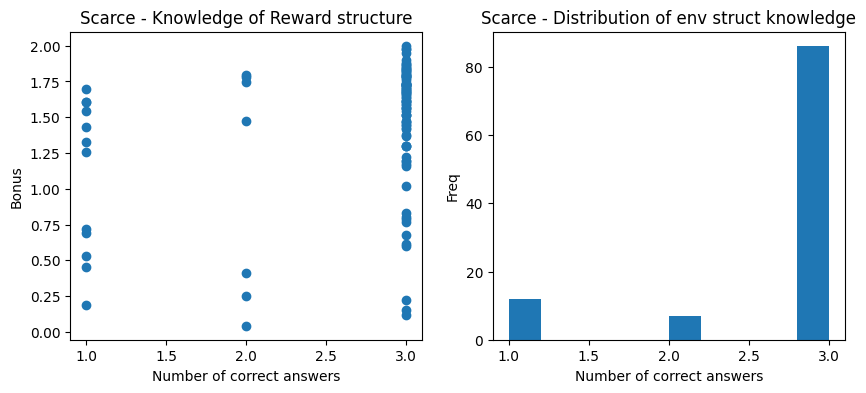

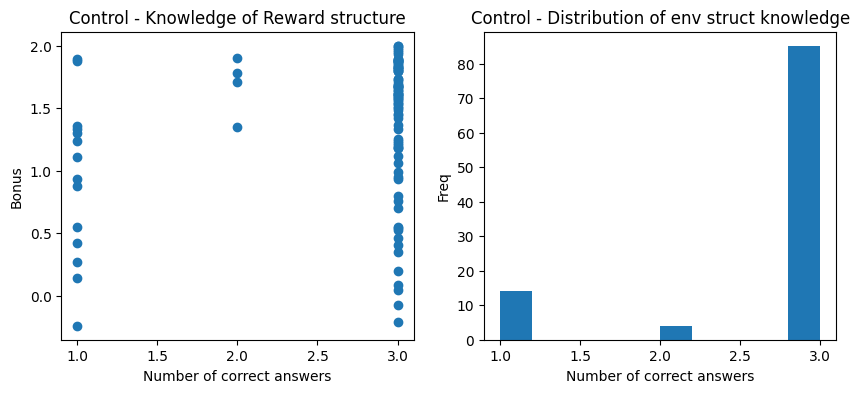

In [48]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(num_correct_s, bonus_s)
plt.xlabel("Number of correct answers")
plt.ylabel("Bonus")
plt.title("Scarce - Knowledge of Reward structure")
plt.subplot(1,2,2)
plt.hist(num_correct_s)
plt.xlabel("Number of correct answers")
plt.ylabel("Freq")
plt.title("Scarce - Distribution of env struct knowledge")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(num_correct_c, bonus_c)
plt.xlabel("Number of correct answers")
plt.ylabel("Bonus")
plt.title("Control - Knowledge of Reward structure")
plt.subplot(1,2,2)
plt.hist(num_correct_c)
plt.xlabel("Number of correct answers")
plt.ylabel("Freq")
plt.title("Control - Distribution of env struct knowledge")

plt.show()